<a href="https://colab.research.google.com/github/thalitadru/ml-class-epf/blob/main/TutorialAutoDiff_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic differentiation software (Auto Diff SW)
*Credits*: compilation of Tensorflow and PyTorch tutorials:
- https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
- https://www.tensorflow.org/guide/autodiff

In [1]:
import numpy as np

import tensorflow as tf
import torch


To differentiate, AutoDiff SW needs to keep a "track record" of the order in which operations are applyed to variables. The SW package then uses this "track record" to compute the gradients of the "recorded" computations using [reverse mode differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). This record takes the form of a **computational graph**.


In order for the entire chain of operations to be differentiable, each operator implemented needs to have a *forward mode*, that gets called to compute the normal operation, along with a *backward mode*, that can be called to compute its derivative.


Using these operators, we only need to explicitly declare the **forward pass**, that is, the computations leading to the expression we want to differentiate (typically a cost function). AutoDiff SW will be able to follow operations backwards and compute gradients for the **backward pass**. 


## A side-note on `Tensor`s

In AutoDiff packages, objects of type `Tensor` are the analogous of of Numpy's `ndarrays` and represent multi-dimensional arrays of arbitrary shape. Most operations available for numpy arrays exist as well for tensors in Tensorflow or PyTorch.

### `tf.Tensor`s and `tf.Variable`s in Tensorflow
Tensorflows differentiates constant-valued tensors from those that can be used as optimization variables (i.e. for which we can compute gradients).
A constant tensor can be created as follows:

In [10]:
t = tf.constant([1,2,3])
t

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3])>

They can be exported to numpy using the dedicated method:

In [11]:
t.numpy()

array([1, 2, 3])

To turn a tensor into a `Variable` we can do:

In [12]:
my_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
my_variable = tf.Variable(my_tensor)

It can also be exported to a numpy array:

In [18]:
my_variable.numpy()

array([[1., 2.],
       [3., 4.]], dtype=float32)

### `torch.Tensor`s in PyTorch
In PyTorch all tensors can be transformed into optimization variables (for which we can compute gradients). What changes is wether the property `requires_grad` is set to `True`.

To create a simple tensor we can do:

In [13]:
t1 = torch.tensor([[1.,2,3],[4,5,6]])
t1

tensor([[1., 2., 3.],
        [4., 5., 6.]])

To have it as a numpy array:

In [16]:
t1.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

The same tensor with gradients (equivalent of the `tf.Variable`) is done with `requres_grad=True`:

In [14]:
t2 = torch.tensor([[1.,2,3],[4,5,6]], requires_grad=True)
t2

tensor([[1., 2., 3.],
        [4., 5., 6.]], requires_grad=True)

Another difference with respect to Tensorflow: to export tensors with gradients to numpy, we must call `detach` before calling `numpy`:

In [19]:
t2.detach().numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

## Example 1: derivative of y = x² with respect to x

### Tensorflow


TensorFlow provides the `tf.GradientTape` API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variable`s.
TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape". 

Here is a simple example:

In [80]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
  y = x**2

Once you've recorded some operations, use `GradientTape.gradient(target, sources)` to calculate the gradient of some target (often a loss) relative to some source (often the model's variables):

In [81]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

We can call `.numpy()` to cast the tensor into a numpy array.

In [82]:
dy_dx.numpy()

6.0

### PyTorch
PyTorch has a built-in differentiation engine called `torch.autograd`. It supports automatic computation of gradient for any computational graph.

In this exemple, we want to be able to compute the gradients of y with respect to x. In order to do that, we set the `requires_grad` property of the tensor containing the dependent variable x.

In [83]:
x = torch.tensor(3.0, requires_grad=True)
y = x**2

**Note**: You can set the value of `requires_grad` when creating a tensor, or later by using `x.requires_grad_(True)` method.

A function that we apply to tensors during the forward pass is in fact an object of class [`Function`](https://pytorch.org/docs/stable/autograd.html#function). This object knows how to compute the function in the *forward* direction, and also how to compute its derivative during the *backward* propagation step. A reference to the backward propagation function is stored in `grad_fn` property of a tensor:

In [84]:
print(f"Gradient function for y = {y.grad_fn}")

Gradient function for y = <PowBackward0 object at 0x7fad16946dd0>


To compute derivatives of y, we call `y.backward()`:

In [85]:
# computes gradients of y with respect to any dependent variables
# having requires_grad=True
y.backward()

Then we retrieve the value of $\partial y/ \partial x$ in `x.grad`

In [86]:
# dy/dx
dy_dx = x.grad
dy_dx

tensor(6.)

Like in Tensorflow, we can call `.numpy()` to cast the tensor into a numpy array.

In [87]:
dy_dx.numpy()

array(6., dtype=float32)

## Example 2: cost derivative for a layer of neurons

In this example we compute forward and backward passes for a single layer of neurons with softmax activation (in other words, we are applying multinomial logistic regression).

In this model, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. 

The following sections show how to implement this graph in Tensorflow and PyTorch. The forward operations are:
$$logits = wx + b$$
$$loss = \mathtt{CrossEntropyFromLogits}(logits, y)$$

Here `CrossEntropyFromLogits` is a function that computes Cross-entropy between target propabilities $y$ and predicted $logits$ (the values predicted prior to aplying sigmoid or softmax).



Here is the forward computational graph for this chain of operations:



![computational graph](https://pytorch.org/tutorials/_images/comp-graph.png)

Here is some example data to test the code: 2 samples with 4 features each, and predicted probabilities for 3 classes

In [88]:
x = [[-2., 2., 2., -2.], [ 2.1, 1., 1.5, -1.]] # input
y = [[1., 0., 0.], [0., 1., 0]] # expected output

This implies we need $w$ to be shape=(4,3) and b to be shape=(3,).

### Tensorflow
The previous example uses scalars, but `tf.GradientTape` works as easily on any tensor. 

Here we use the built-in cost function [`tf.nn.softmax_cross_entropy_with_logits`](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits) which expects not the predicted probabilities, but the logits (prior to the application of softmax):

In [89]:
# parameters
w = tf.Variable(tf.random.normal((4, 3)), name='w')
b = tf.Variable(tf.zeros(3, dtype=tf.float32), name='b')

# Computations we want to track get done with the GradientTape context
with tf.GradientTape() as tape:
    # NOTE tensorflow is implcitly casting x and y to tf.Tensor
    logits = x @ w + b
    loss = tf.nn.softmax_cross_entropy_with_logits(y,logits)


To get the gradient of `loss` with respect to both variables, you can pass both as sources to the `gradient` method. The tape is flexible about how sources are passed and will accept any nested combination of lists or dictionaries and return the gradient structured the same way (see `tf.nest`).

In [90]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

The gradient with respect to each source has the shape of the source:

In [91]:
print(w.shape)
print(dl_dw.shape)

(4, 3)
(4, 3)


A `GradientTape` may be used only once to compute gradients. After that the computational graph is erased. 

In [92]:
# This should raise an error
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

RuntimeError: ignored

To be able to repeat the gradient computations, you need to set `persistent=True` when instantiating `GradientTape`:

In [94]:
# Need to regriate the forwad computations, this time with persistent gradient tape
with tf.GradientTape(persistent=True) as tape:
    # NOTE tensorflow is implcitly casting x and y to tf.Tensor
    logits = x @ w + b
    loss = tf.nn.softmax_cross_entropy_with_logits(y,logits)

# Now gradients can be computed multiple times
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

Here is the gradient calculation again, this time passing a dictionary of variables. In this case gradients are returned in a dictionnary with the same indexed as the input:

In [ ]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
grad['b']

### PyTorch
PyTorch will also compute the backward pass for arbitrary-sized tensors. 
It is more strict about the type of inputs and targets, that must be cast to `torch.tensor` explicitly prior to manipulation.

Here we use the built-in cost function [`torch.nn.functional.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy) which expects not the predicted probabilities, but the logits (prior to the application of softmax)

In [95]:
# parameters
w = torch.randn(4, 3, requires_grad=True)
b = torch.zeros(3, requires_grad=True)

# NOTE in Pytorch we need to cast x and y to tensors explicitly
logits = torch.matmul(torch.tensor(x), w) + b

loss = torch.nn.functional.cross_entropy(logits, torch.tensor(y))

We call `loss.backward()` to compute the derivatives with respect to all dependent variables (w and b):

In [96]:
loss.backward()

Then gradients can be retrieved under `w.grad` and `b.grad`:

In [97]:
[dl_dw, dl_db] = w.grad, b.grad

As expected, the gradient with respect to each source has the shape of the source:

In [98]:
print(w.shape)
print(dl_dw.shape)

torch.Size([4, 3])
torch.Size([4, 3])


We can only perform gradient calculations using backward once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass `retain_graph=True` to the backward call.

In [99]:
# this will raise an error
loss.backward()

RuntimeError: ignored

In [100]:
# need to recriate the forward graph and use retain_graph=True in backward call
logits = torch.matmul(torch.tensor(x), w) + b

loss = torch.nn.functional.cross_entropy(logits, torch.tensor(y))

loss.backward(retain_graph=True)

# Sugested exercises

## (Exercise 1) Simple regression
- Goal: make variable `x` approach `target`
- How: apply gradient descent: update `x.data` in the oposite direction of `x.grad`

The target will consist of increasing values from 1 to 5:

In [94]:
# In TF:
target_tf = tf.range(5.0)
# In PyTorch:
target_torch = torch.arange(5.0)

Before we continue, create the variable x in both tensorflow and Pytorch. Initialize it to small random values.
Tip: check out [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html#torch-rand) and [`tf.random.uniform`](https://www.tensorflow.org/api_docs/python/tf/random/uniform)

In [ ]:
#TODO Your code here
x_tf =
x_torch = 

In [95]:
#SOLUTION
x_tf = tf.Variable(tf.random.uniform(shape=[5]))
x_torch = torch.rand(5, requires_grad=True)

Let's visualize the current state of our variable x along with the target:

In [99]:
import matplotlib.pyplot as plt

def plot(x, target):
    if isinstance(x, torch.Tensor):
        x = x.detach()
    plt.plot(target.numpy(), 'o ', ms=15, label= 'target')
    plt.plot(x.numpy(), '* ', ms=15, label='variable x'); plt.legend()
    plt.ylabel("value")
    plt.xlabel("sample")
    print('x: ', x, '\ntarget:', target)


Here are the tensorflow arrays:

x:  <tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([0.525221  , 0.08639467, 0.47554135, 0.51579607, 0.5295665 ],
      dtype=float32)> 
target: tf.Tensor([0. 1. 2. 3. 4.], shape=(5,), dtype=float32)


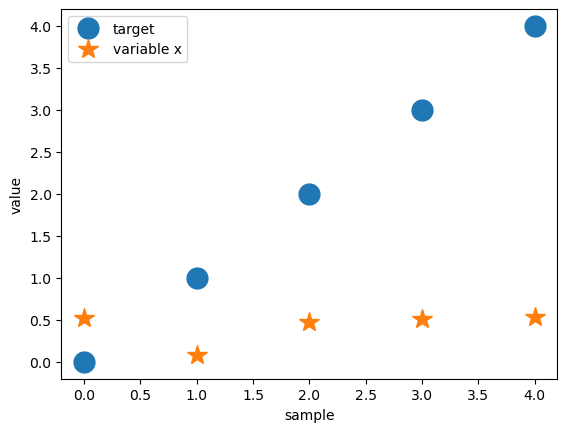

In [100]:
plot(x_tf,target_tf)

Here goes the pytorch counterpart:

x:  tensor([0.9935, 0.0700, 0.2596, 0.1772, 0.7707]) 
target: tensor([0., 1., 2., 3., 4.])


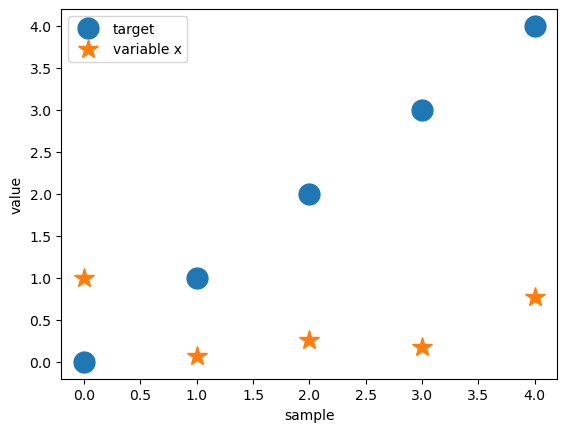

In [101]:
plot(x_torch,target_torch)

To make x match target, we need to write an optimization loop. We will work on each of the frameworks separately:

#### On Tensorflow
1. Open a `tf.GradientTape` context using a `with` block
2. Within the with block, use `tf.math.reduce_mean` and `tf.pow` the mean squared error between x and target. This will be your loss function.
3. Outside of the with block, compute the loss gradient with respect to x using the method `gradient` and the `tape` you created
4. Update the variable x using a gradient descent step. **Attention**: you **MUST** use inplace assignment methods like `assign` or `assign_sub` (i.e., do not overwite `x_tf` by writign something like `x_tf = ...` or `x_tf -= ...`).

In [ ]:
lr = learning_rate = 0.1

for _ in range(150):
    #TODO complete the code bellow
    # 1) Open a `tf.GradientTape` context using a with block
    with ... as tape:
        # 2) within the with block, compute the mean squared error between x and target
        loss = ...
    # 3) Outside of the with block, compute the gradient with respect to x
    ...
    # 4) update x according to the computed gradient
    x_tf.assign...


In [102]:
#SOLUTION
lr = learning_rate = 0.1

for _ in range(150):
    # 1) Open a `tf.GradientTape` context using a with block
    with tf.GradientTape(persistent=True) as tape:
        # 2) within the with block, compute the mean squared error between x and target
        loss = tf.math.reduce_mean(tf.pow(x_tf - target_tf, 2))
    # 3) Outside of the with block, compute the gradient with respect to x
    grad_x = tape.gradient(loss, x_tf)
    # 4) update x according to the computed gradient
    x_tf.assign_sub(lr * grad_x)


##### Result
After a few iterations, we should have x matching the target. We can redo the plots to visualize the plue circles now match the star targets:

x:  <tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([1.1508717e-03, 9.9799812e-01, 1.9966598e+00, 2.9945567e+00,
       3.9923956e+00], dtype=float32)> 
target: tf.Tensor([0. 1. 2. 3. 4.], shape=(5,), dtype=float32)


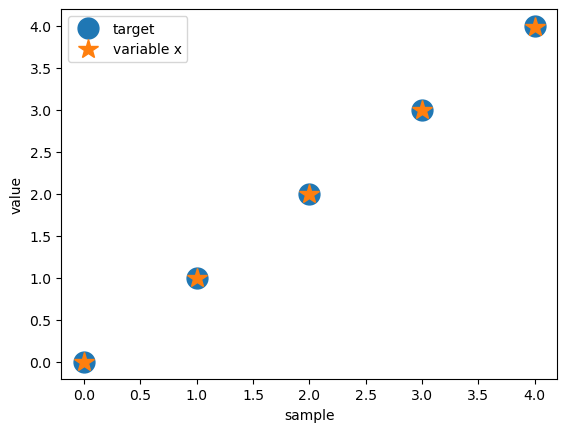

In [104]:
plot(x_tf,target_tf)

#### On PyTorch
1. using `torch.mean` and `torch.pow`, compute the mean squared error between x and target. This will be your loss function.
2. Compute the gradients with `backward`. Don't forget you want to keep the graph for the next iterations.
3. Apply the gradient descent step by updating `x.data` according to `x.grad` (and a learning rate)
4. Zero the gradient of x before the next iteration using the method `zero_` on `x.grad` (`zero_`` method fills tensors with 0s inplace)

In [43]:
lr = learning_rate = 0.1
for _ in range(150):
    # TODO complete the code bellow
    # 1) compute mean squared error between x and target
    loss = 
    # 2) compute the gradients
    ...
    # 3) update x.data according to x.grad
    x_torch.data ...
    # 4) backward accumulates gradients, so zero them before next call to backward
    ...

In [103]:
#SOLUTION
lr = learning_rate = 0.1
for _ in range(150):
    # 1) compute mean squared error between x and target
    loss = torch.mean(torch.pow((x_torch - target_torch), 2))
    # 2) compute the gradients
    loss.backward(retain_graph=True)
    # 3) update x.data according to x.grad
    x_torch.data -=  lr * x_torch.grad.data
    # 4) backward accumulates gradients, so zero them before next call to backward
    x_torch.grad.zero_()  # (.zero_ method fills tensors with 0s in-place)

##### Result
After a few iterations, we should have x matching the target. We can redo the plots to visualize the plue circles now match the star targets:

Here goes the pytorch counterpart:

x:  tensor([2.1771e-03, 9.9796e-01, 1.9962e+00, 2.9938e+00, 3.9929e+00]) 
target: tensor([0., 1., 2., 3., 4.])


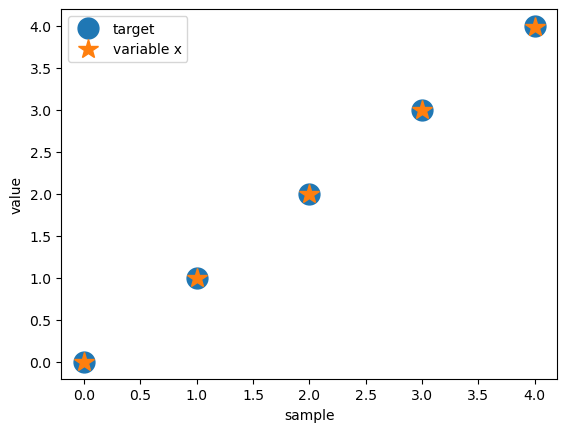

In [105]:
plot(x_torch,target_torch)

## (Exercise 2) Logistic regression
A single neuron with sigmoid activation is mathematically equivalent to a logistic model. 

Considering vectorized samples (inputs in a matrix $X$, targets in a vector $y$), both are given by:
$$ y = \sigma (Xw + b )$$
where the learnable parameters are: 
- the weight vector `W` and 
- the vector of intercepts `b`

Using the code from  "Example 2", you are going to apply gradient descent on the parameters in order to learn a decision boundary for the folloing toy problem:

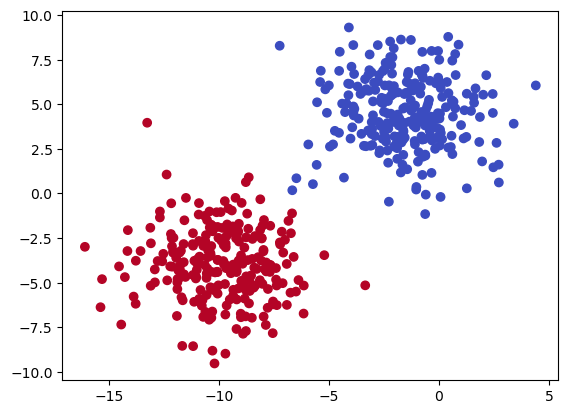

In [48]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

n_classes = 2
X, y = make_blobs(n_samples=500, n_features=2, centers=n_classes, 
                  cluster_std=2, random_state=1)
X, y = X.astype('float32'), y.astype('float32')
plt.scatter(*X.T, c=y, cmap='coolwarm')

You can visualize the learned decision functions using the plotting function defined bellow:

In [33]:
from typing import Optional


def frontier_plot(w:Optional[tf.Tensor|torch.Tensor], b:Optional[tf.Tensor|torch.Tensor]):
    # evenly sampled points
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    #plot background colors
    ax = plt.gca()
    new_x = np.c_[xx.ravel(), yy.ravel()]
    if isinstance(w, torch.Tensor):
        w = w.detach()
        b = b.detach()
    Z = tf.nn.sigmoid(new_x @ w.numpy() + b.numpy()).numpy()
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap='coolwarm', alpha=.5)
    cs2 = ax.contour(xx, yy, Z, cmap='coolwarm', alpha=.5)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    plt.title('decision boundary')
    plt.scatter(*X.T, c=y, cmap='coolwarm')


**Tip**: You can almost completely reuse the code from Example 2. The adjustments you need to make are:
- Match the shapes of w and b to those of the new toy data.
- Use a loss function that computes sigmoid of the logits (instead of softmax).
- After applying the cross-entropy function, aggregate the results across all samples with a sum or mean function.
- Update the values of w and b properly.
- PyTorch only: reset gradients to zero on w and b.

#### Tensorflow
Here are the new funcitons you will need:
- `tf.squeeze`
- `tf.reduce_mean`
- `tf.nn.sigmoid_cross_entropy_with_logits`

In [ ]:
# hyperparameters
learning_rate = lr = 0.01
#TODO complete the code bellow
# create your parameters
w_tf = ...
b_tf = ...
# Monitoring
loss_curve_tf = []
# Optimization loop
for _ in range (150):
    # Open the GradientTape context
    with ... as tape:
        # compute logits
        logits = ...
        # they must have the same shape as y
        assert logits.shape == y.shape
        # compute the loss
        loss = ...
    # compute gradients
    ...
    # Update w and b 
    w_tf.assign...
    b_tf.assign...

    # log values to plot a learning curve
    loss_curve_tf.append(loss.numpy())

In [86]:
#SOLUTION
# hyperparameters
learning_rate = lr = 0.01
# parameters
w_tf = tf.Variable(tf.random.uniform([2, 1]), name='w')
b_tf = tf.Variable(0., name='b')
# Monitoring
loss_curve_tf = []
# Optimization loop
for _ in range (150):
    # Computations we want to track get done with the GradientTape context
    with tf.GradientTape(persistent=True) as tape:
        # Compute the logits
        # NOTE tensorflow is implcitly casting x and y to tf.Tensor
        logits = tf.squeeze(X @ w_tf + b_tf)
        # they must have the same shape as y
        assert logits.shape == y.shape
        # compute the loss
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            y, logits))
     # compute gradients
    [dl_dw, dl_db] = tape.gradient(loss, [w_tf, b_tf])

    # Update w and b 
    w_tf.assign_sub(lr*dl_dw)
    b_tf.assign_sub(lr*dl_db)

    # log values to plot a learning curve
    loss_curve_tf.append(loss.numpy())

##### Result

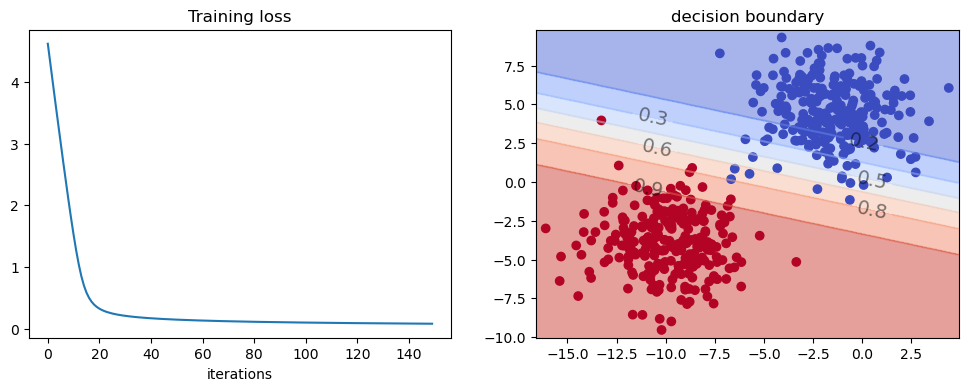

In [87]:
# Tensorflow
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_curve_tf)
plt.title('Training loss'); plt.xlabel('iterations')
plt.subplot(1,2,2)
frontier_plot(w_tf, b_tf)

#### Pytorch
Here are the new functions you will need:
- `torch.from_numpy`
- `torch.nn.functional.binary_cross_entropy_with_logits`
- `torch.mean`

In [53]:
# hyperparameters
learning_rate = lr = 0.01
#TODO Complete the code bellow
# parameters
w_torch = ...
b_torch = ...
# Monitoring
loss_curve_torch = []
# Optimization loop
for _ in range (150):
    # compute logits
    logits = ...
    # compute loss
    loss = ...
    # compute gradients
    ...
    # update parameters
    w_torch...
    b_torch...
    # Reset gradients to zero
    w_torch.grad...
    b_torch.grad...

    # log values to plot a learning curve
    loss_curve_tf.append(loss.data.numpy())

In [89]:
#SOLUTION
# hyperparameters
learning_rate = lr = 0.01
# parameters
w_torch = torch.rand(2, requires_grad=True)
b_torch = torch.tensor(0., requires_grad=True)
# Monitoring
loss_curve_torch = []
# Optimization loop
for _ in range (150):
    # compute logits
    logits = torch.matmul(torch.from_numpy(X), w_torch) + b_torch
    # compute loss
    loss = torch.mean(torch.nn.functional.binary_cross_entropy_with_logits(
        logits, torch.from_numpy(y)
        ))
    # ocpute gradients
    loss.backward(retain_graph=True)
    # update parameters
    w_torch.data.sub_(lr * w_torch.grad)
    b_torch.data.sub_(lr * b_torch.grad)
    # Reset gradients to zero
    w_torch.grad.zero_()
    b_torch.grad.zero_()

    # log values to plot a learning curve
    loss_curve_torch.append(loss.data.numpy())

##### Result

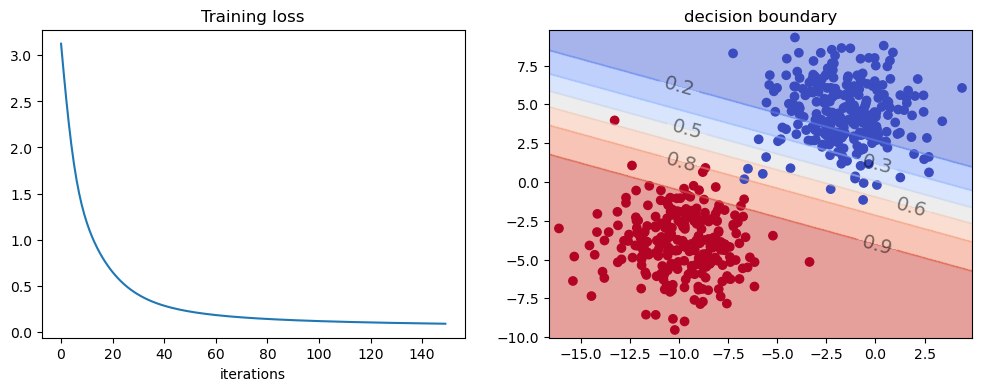

In [90]:
# PyTorch
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_curve_torch)
plt.title('Training loss'); plt.xlabel('iterations')
plt.subplot(1,2,2)
frontier_plot(w_torch, b_torch)